# Product Sales Forecasting: Prophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
import itertools

In [ ]:
path = '/content/drive/MyDrive/Product Sales Forecasting/data/'

# Get train and test data using 'date' as the index
train = pd.read_csv(f'{path}train.csv', usecols=['date', 'qty'], parse_dates=['date'])
test = pd.read_csv(f'{path}test.csv', usecols=['date', 'qty', 'closed_day'], parse_dates=['date'])

# Get list of closed days for test data, and drop 'closed_day' column
test_closed_days = test[test['closed_day'] == 1]['date']
test = test.drop('closed_day', axis=1)

# Rename columns for use with Prophet
train.rename(columns={'date': 'ds', 'qty': 'y'}, inplace=True)
test.rename(columns={'date': 'ds', 'qty': 'y'}, inplace=True)

# Combine train and test sets
df_full = pd.concat([train, test])

# Range of years
years = range(df_full.iloc[0]['ds'].year, df_full.iloc[-1]['ds'].year + 1)

# Cutoff dates for cross-validation
val_cutoffs = pd.date_range(start=train.iloc[-365]['ds'], periods=13, freq='28D')
test_cutoffs = pd.date_range(start=train.iloc[-1]['ds'], periods=13, freq='28D')

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2344 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2344 non-null   datetime64[ns]
 1   y       2344 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 54.9 KB


In [ ]:
#@title Make Holidays

# Back-to-School season (7 days of July + first 15 days of August)
back_to_school = pd.DataFrame({
    'holiday': 'back_to_school',
    'ds': pd.to_datetime([f'{y}-08-01' for y in years]),
    'lower_window': -7,
    'upper_window': 14
})

# Christmas holiday season (2 weeks before Christmas, 12/11-12/24)
christmas_leadup = pd.DataFrame({
    'holiday': 'christmas_season',
    'ds': pd.to_datetime([f'{y}-12-24' for y in years]), # Christmas Eve
    'lower_window': -13,  # 14 days before Christmas
    'upper_window': 0
})

holidays = pd.concat([back_to_school, christmas_leadup])
holidays

,holiday,ds,lower_window,upper_window
0,back_to_school,2019-08-01,-7,14
1,back_to_school,2020-08-01,-7,14
2,back_to_school,2021-08-01,-7,14
3,back_to_school,2022-08-01,-7,14
4,back_to_school,2023-08-01,-7,14
5,back_to_school,2024-08-01,-7,14
6,back_to_school,2025-08-01,-7,14
0,christmas_season,2019-12-24,-13,0
1,christmas_season,2020-12-24,-13,0
2,christmas_season,2021-12-24,-13,0


In [ ]:
def evaluate_preds(y, y_pred, label, folds=False):
    '''
        Return RMSE, MAE, and sMAPE scores
        y, y_pred, and label may be tuples of same length for evaluation on multiple sets
        folds indicates that scores should be evaluated as the mean across folds,
          in this case, y and y_pred must consist of exactly 364 days
    '''

    # Compute sMAPE
    def smape_score(y_true, y_pred):
      denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
      diff = np.abs(y_pred - y_true)
      mask = denominator != 0 # Avoid division by zero
      smape_val = np.mean(diff[mask] / denominator[mask]) * 100
      return smape_val

    trues = y if isinstance(y, (tuple)) else (y,)
    preds = y_pred if isinstance(y_pred, (tuple)) else (y_pred,)

    rmse = []
    mae = []
    smape = []

    for true, pred in zip(trues, preds):
      if folds:
        rmses = []
        maes = []
        smapes = []
        # Scores across cv folds
        for i in range(0, 364, 28):
          true_fold = true.iloc[i:i + 28]
          pred_fold = pred.iloc[i:i + 28]
          rmses.append(root_mean_squared_error(true_fold, pred_fold))
          maes.append(mean_absolute_error(true_fold, pred_fold))
          smapes.append(smape_score(true_fold, pred_fold))
        # Mean of scores across folds
        rmse.append(round(np.mean(rmses), 4))
        mae.append(round(np.mean(maes), 4))
        smape.append(round(np.mean(smapes), 4))
      else:
        rmse.append(round(root_mean_squared_error(true, pred), 4))
        mae.append(round(mean_absolute_error(true, pred), 4))
        smape.append(round(smape_score(true, pred), 4))

    scores = pd.DataFrame({'RMSE': rmse, 'MAE': mae, 'sMAPE': smape})
    scores.index = label if isinstance(label, (tuple)) else (label,)

    return(scores)

# Plot forecast
def plot_forecast(train, forecast, title):
  y_train = train.set_index('ds')['y']
  pred = forecast.set_index('ds')

  plt.figure(figsize=(16, 4))
  y_train.iloc[-364:].plot(label='Train')
  pred['y'].plot(label='Actual')
  pred['yhat'].plot(label='Forecast')
  for i in range(0, pred.shape[0], 28):
    plt.axvline(x=pred.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)

  # Prediction Interval
  plt.fill_between(
    pred.index,
    pred['yhat_lower'],
    pred['yhat_upper'],
    color='blue',
    alpha=0.2,
    label='Prediction Interval (95%)'
  )

  plt.title(title)
  plt.legend()
  plt.show()

## Default Prophet Model

Default model with holidays but no hyperparameter tuning

In [ ]:
import logging

# Disable output logs
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [ ]:
start_time = time.time()

m_baseline = Prophet(holidays=holidays)
m_baseline.add_country_holidays(country_name='US')
m_baseline.fit(train)

print(f"Fit time: {round(time.time() - start_time, 2)} seconds")

fitted_bl = m_baseline.predict(train)
forecast_bl = m_baseline.predict(test)
forecasts_bl = pd.concat([fitted_bl, forecast_bl])

Fit time: 9.54 seconds


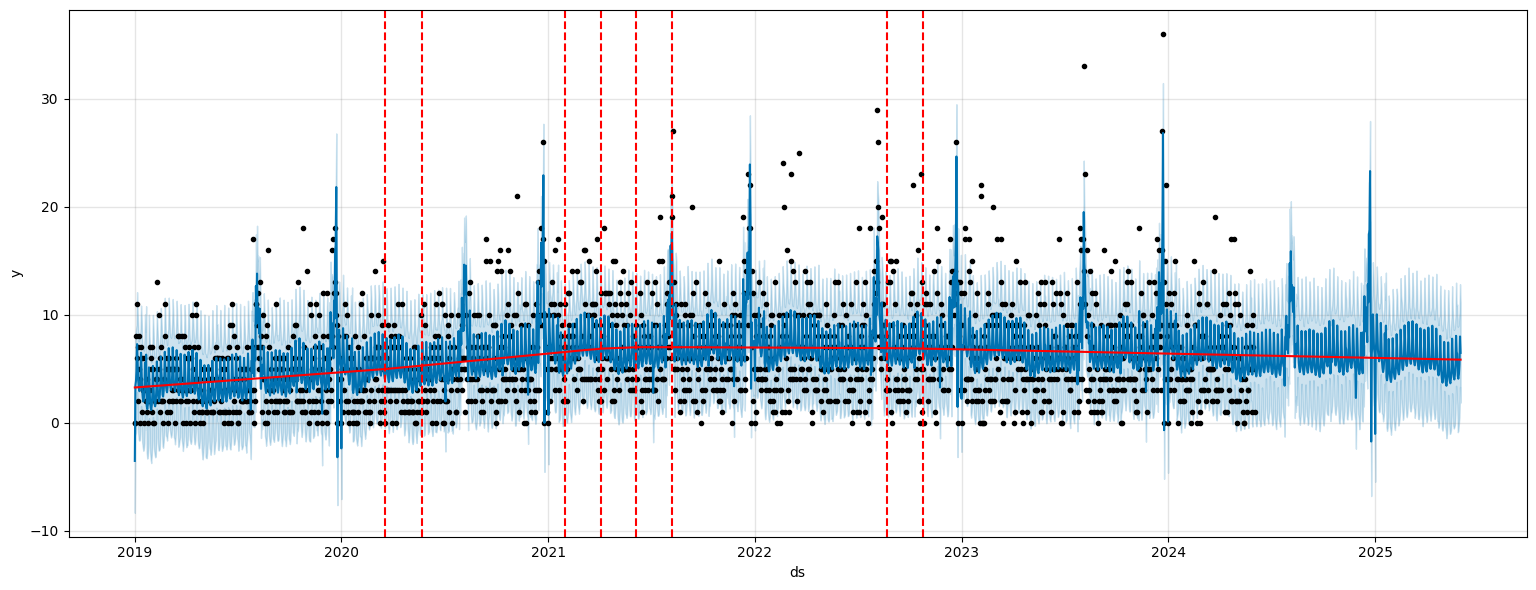

In [ ]:
fig = m_baseline.plot(forecasts_bl)
fig.set_size_inches(16, 6)
a = add_changepoints_to_plot(fig.gca(), m_baseline, forecasts_bl)

In [ ]:
# Print changepoints with average delta >= default threshold of 0.01
changepoints = m_baseline.changepoints
deltas = m_baseline.params['delta'].mean(axis=0)

print("Significant Changepoints:")
print(changepoints[np.abs(deltas) >= 0.01])

Significant Changepoints:
443    2020-03-19
507    2020-05-22
760    2021-01-30
823    2021-04-03
886    2021-06-05
950    2021-08-08
1330   2022-08-23
1393   2022-10-25
Name: ds, dtype: datetime64[ns]


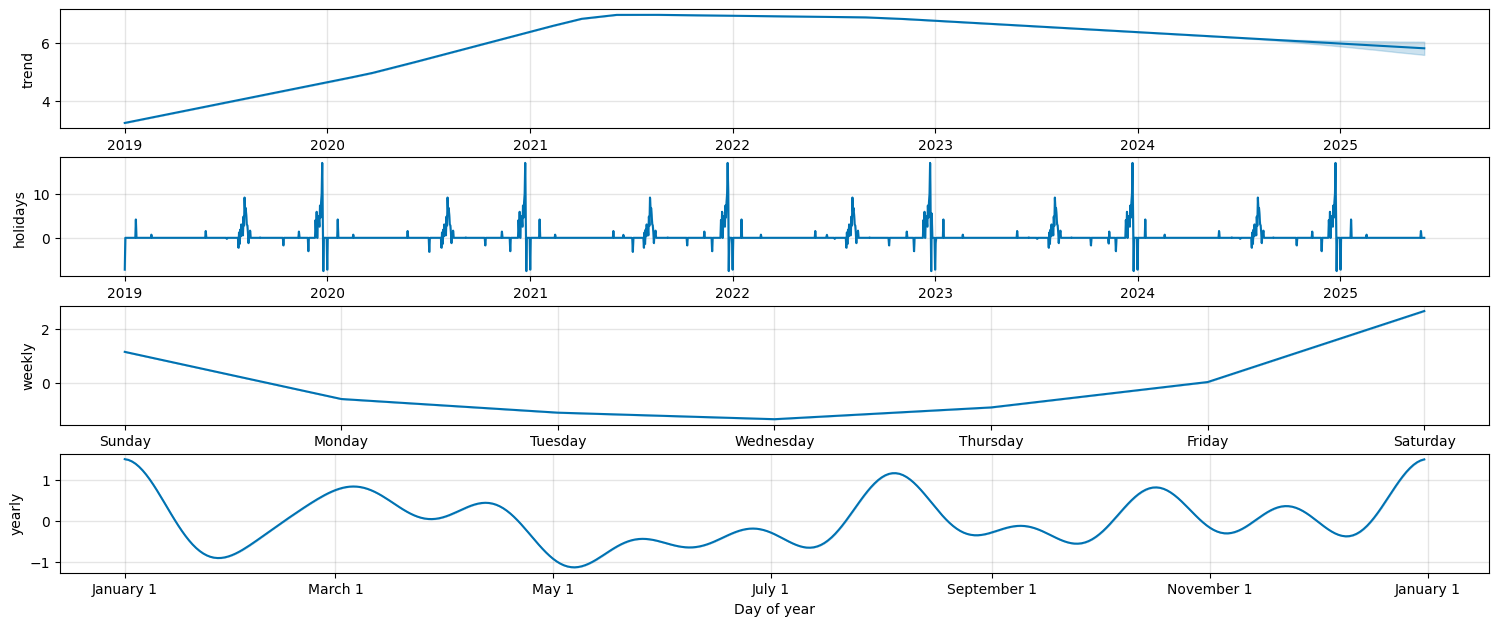

In [ ]:
fig = m_baseline.plot_components(forecasts_bl)
fig.set_size_inches(16, 6)

In [ ]:
m_baseline.train_holiday_names.unique()

array(['back_to_school', 'christmas_season', "New Year's Day",
       'Memorial Day', 'Independence Day', 'Labor Day', 'Veterans Day',
       'Thanksgiving Day', 'Christmas Day', 'Martin Luther King Jr. Day',
       "Washington's Birthday", 'Columbus Day',
       'Independence Day (observed)', "New Year's Day (observed)",
       'Juneteenth National Independence Day',
       'Juneteenth National Independence Day (observed)',
       'Christmas Day (observed)', 'Veterans Day (observed)'],
      dtype=object)

In [ ]:
m_baseline = Prophet(holidays=holidays)
m_baseline.add_country_holidays(country_name='US')
m_baseline.fit(df_full)

# Cross-validation with test set
cv_bl = cross_validation(
    m_baseline,
    horizon='28 days',
    cutoffs=test_cutoffs,
    parallel="processes"
)

# Set forecasts for closed days (i.e. Christmas, New Year's Day) to 0
cv_bl.loc[cv_bl['ds'].isin(test_closed_days), 'yhat'] = 0

train_scores_bl = evaluate_preds(train['y'], fitted_bl['yhat'], 'Prophet (Baseline) Train Scores')
test_scores_bl = evaluate_preds(test['y'], cv_bl['yhat'], 'Prophet (Baseline) Test Scores', folds=True)

scores_bl = pd.concat([train_scores_bl, test_scores_bl])
display(scores_bl)

,RMSE,MAE,sMAPE
Prophet (Baseline) Train Scores,3.6545,2.8455,53.877
Prophet (Baseline) Test Scores,3.6356,2.9122,64.051


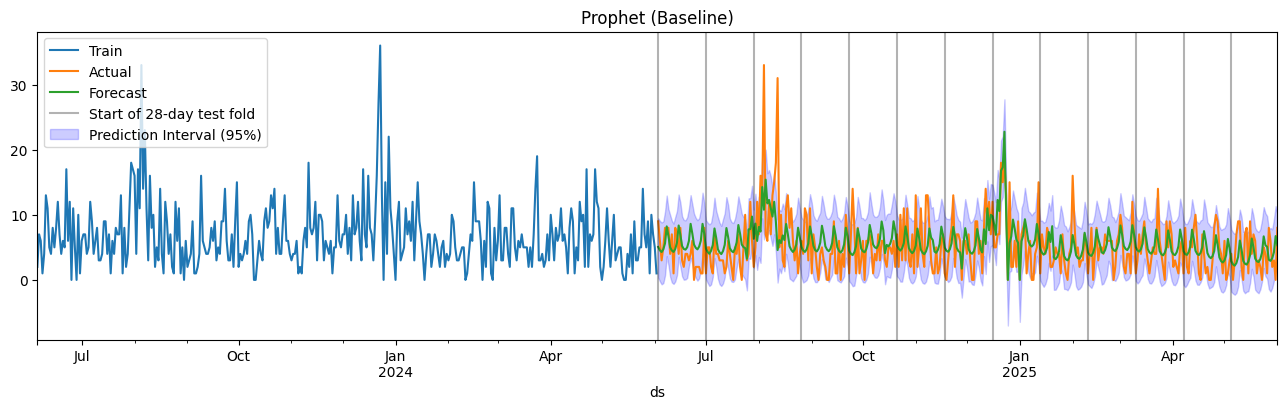

In [ ]:
plot_forecast(train, cv_bl, 'Prophet (Baseline)')

## Hyperparameter Tuning

In [ ]:
# Grid Search
'''
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [10, 15, 20, 25]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    m = Prophet(holidays=holidays, **params)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    df_cv = cross_validation(m, horizon='28 days', cutoffs=val_cutoffs, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results.sort_values(by='rmse').head(20)
'''

'\nparam_grid = {  \n    \'changepoint_prior_scale\': [0.01, 0.05, 0.1],\n    \'seasonality_prior_scale\': [0.01, 0.1, 1.0, 10.0],\n    \'holidays_prior_scale\': [0.01, 0.1, 1.0, 10.0],\n    \'yearly_seasonality\': [10, 15, 20, 25]\n}\n\n# Generate all combinations of parameters\nall_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]\nrmses = []\n\n# Use cross validation to evaluate all parameters\nfor params in tqdm(all_params):\n    m = Prophet(holidays=holidays, **params)\n    m.add_country_holidays(country_name=\'US\')\n    m.fit(train)\n    df_cv = cross_validation(m, horizon=\'28 days\', cutoffs=val_cutoffs, parallel="processes")\n    df_p = performance_metrics(df_cv, rolling_window=1)\n    rmses.append(df_p[\'rmse\'].values[0])\n\n# Find the best parameters\ntuning_results = pd.DataFrame(all_params)\ntuning_results[\'rmse\'] = rmses\ntuning_results.sort_values(by=\'rmse\').head(20)\n'

In [ ]:
best_params = {
  'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 1,
  'holidays_prior_scale': 1,
  'yearly_seasonality': 10
}

start_time = time.time()

m_tuned = Prophet(holidays=holidays, **best_params)
m_tuned.add_country_holidays(country_name='US')
m_tuned.fit(train)

print(f"Fit time: {round(time.time() - start_time, 2)} seconds")

fitted_tuned = m_tuned.predict(train)
forecast_tuned = m_tuned.predict(test)
forecasts_tuned = pd.concat([fitted_tuned, forecast_tuned])

Fit time: 0.7 seconds


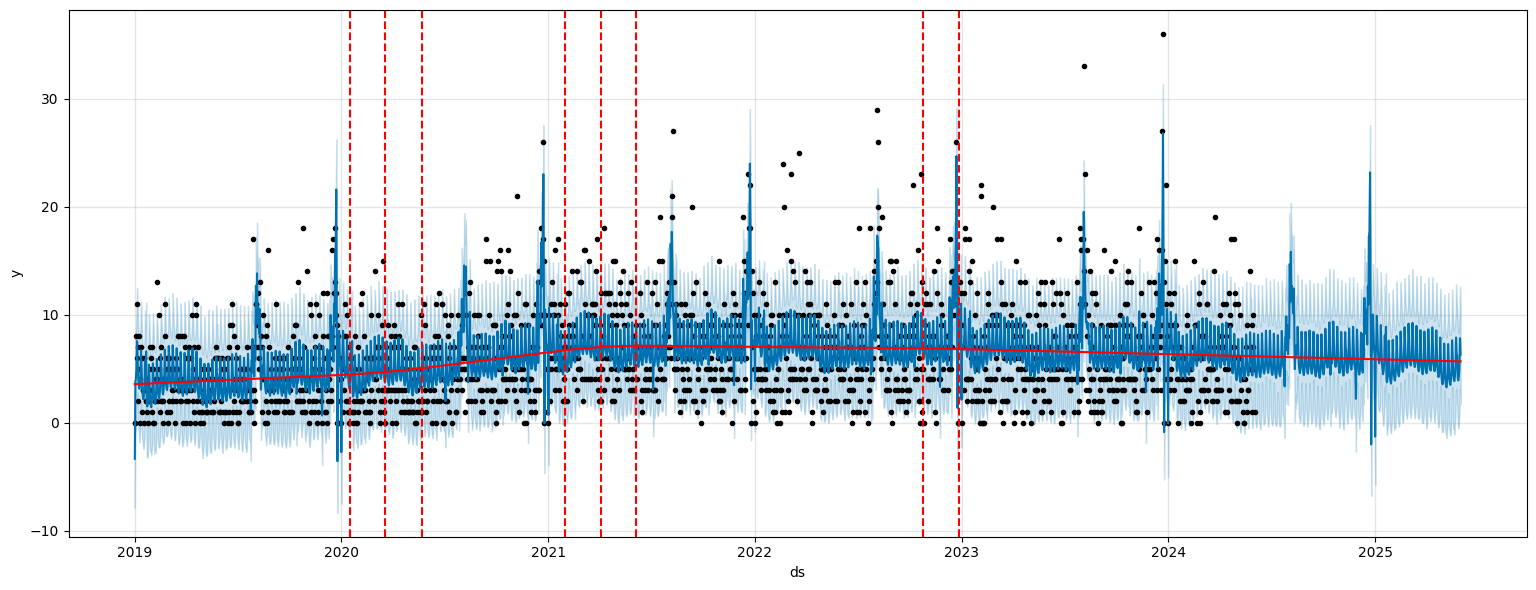

In [ ]:
fig = m_tuned.plot(forecasts_tuned)
fig.set_size_inches(16, 6)
a = add_changepoints_to_plot(fig.gca(), m_tuned, forecasts_tuned)

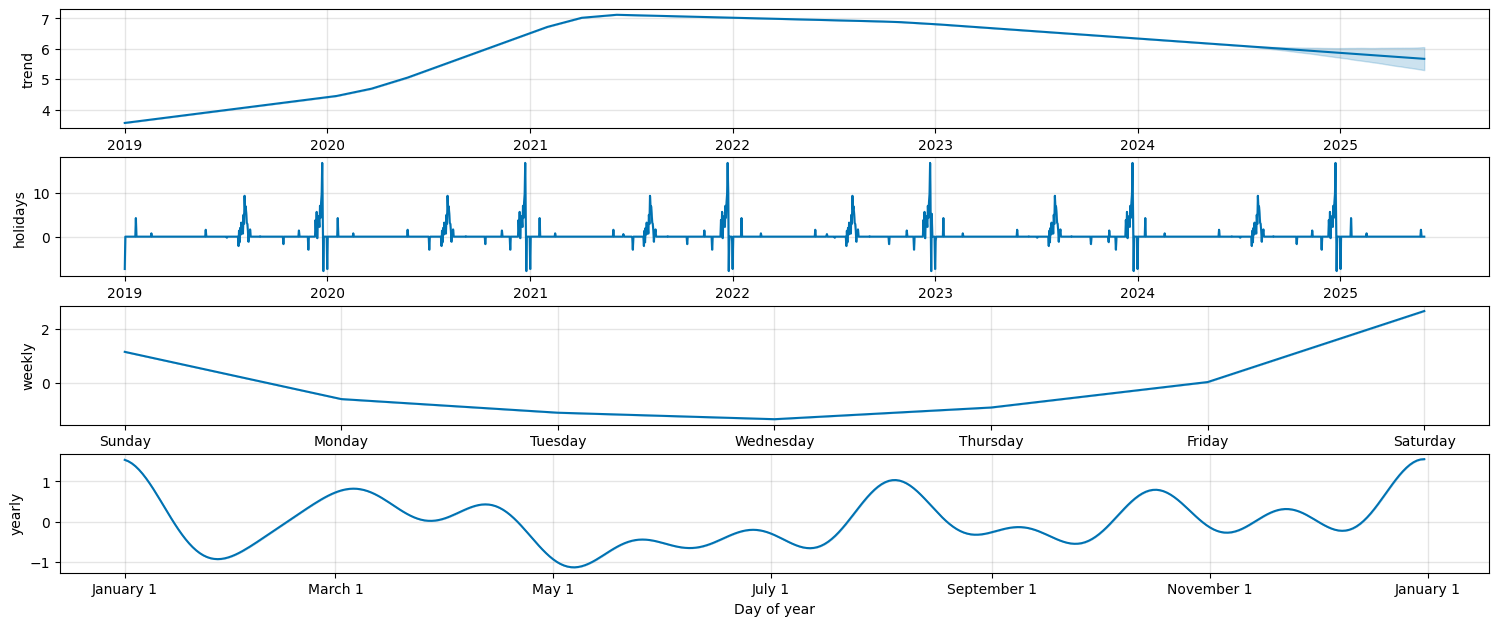

In [ ]:
fig = m_tuned.plot_components(forecasts_tuned)
fig.set_size_inches(16, 6)

,RMSE,MAE,sMAPE
Prophet (Hyperparameter Tuned) Train Scores,3.6468,2.8370,53.6990
Prophet (Hyperparameter Tuned) Test Scores,3.6152,2.8855,64.0489
Prophet (Baseline) Train Scores,3.6545,2.8455,53.8770
Prophet (Baseline) Test Scores,3.6356,2.9122,64.0510


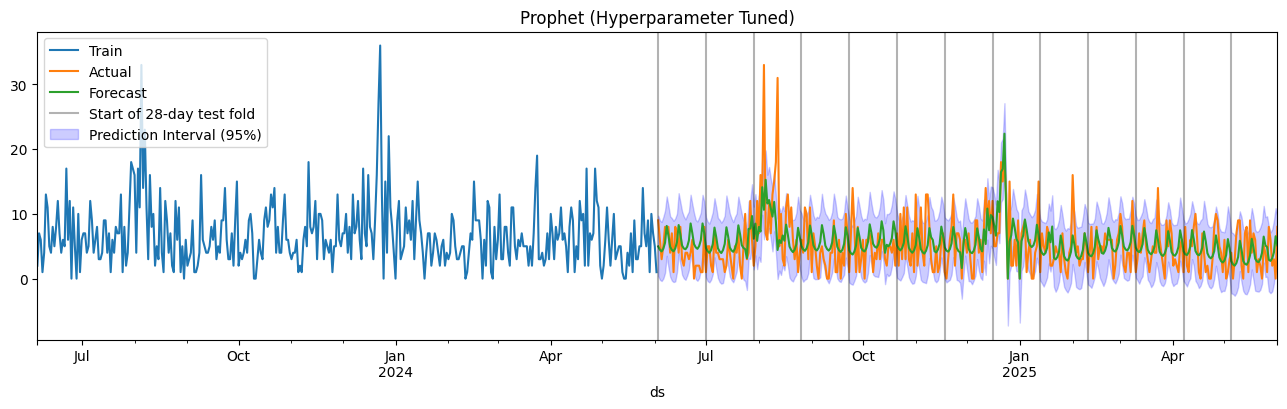

In [ ]:
m_tuned = Prophet(holidays=holidays, **best_params)
m_tuned.add_country_holidays(country_name='US')
m_tuned.fit(df_full)

# Cross-validation with test set
cv_tuned = cross_validation(
    m_tuned,
    horizon='28 days',
    cutoffs=test_cutoffs,
    parallel="processes"
)

# Set forecasts for closed days (i.e. Christmas, New Year's Day) to 0
cv_tuned.loc[cv_tuned['ds'].isin(test_closed_days), 'yhat'] = 0

train_scores_tuned = evaluate_preds(train['y'], fitted_tuned['yhat'], 'Prophet (Hyperparameter Tuned) Train Scores')
test_scores_tuned = evaluate_preds(test['y'], cv_tuned['yhat'], 'Prophet (Hyperparameter Tuned) Test Scores', folds=True)

scores_tuned = pd.concat([train_scores_tuned, test_scores_tuned])
display(pd.concat([scores_tuned, scores_bl]))

plot_forecast(train, cv_tuned, 'Prophet (Hyperparameter Tuned)')

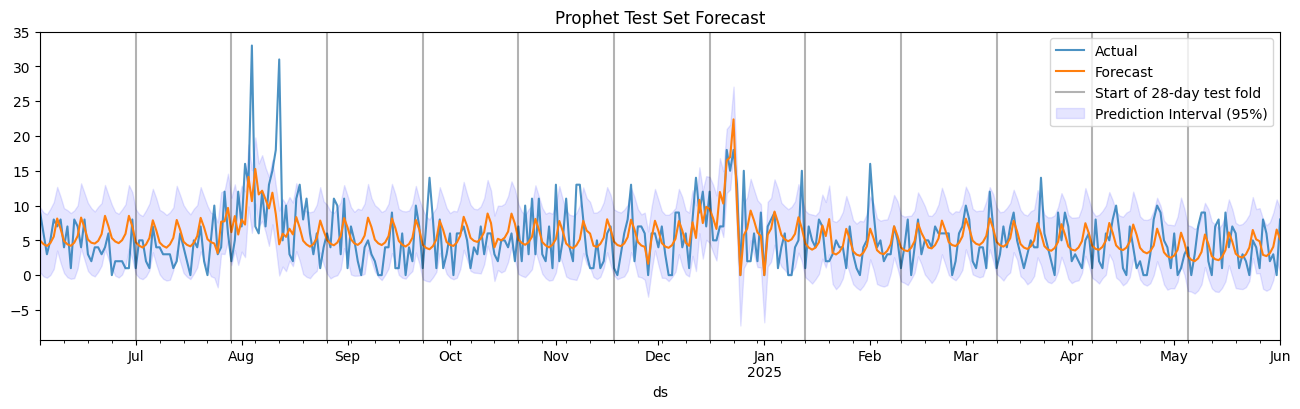

In [ ]:
y_train = train.set_index('ds')['y']
y_test = test.set_index('ds')['y']
pred = cv_tuned.set_index('ds')

plt.figure(figsize=(16, 4))
y_test.plot(label='Actual', alpha=0.8)
pred['yhat'].plot(label='Forecast')
for i in range(0, len(y_test), 28):
  plt.axvline(x=y_test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)

# Prediction Interval
plt.fill_between(
  pred.index,
  pred['yhat_lower'],
  pred['yhat_upper'],
  color='blue',
  alpha=0.1,
  label='Prediction Interval (95%)'
)

plt.title('Prophet Test Set Forecast')
plt.legend()
plt.show()

## Residual Analysis

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

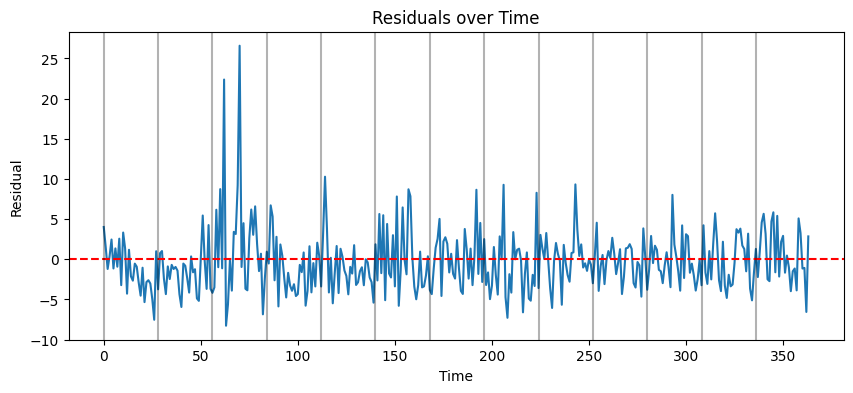

In [ ]:
residuals = test['y'] - cv_tuned['yhat']

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
plt.show()

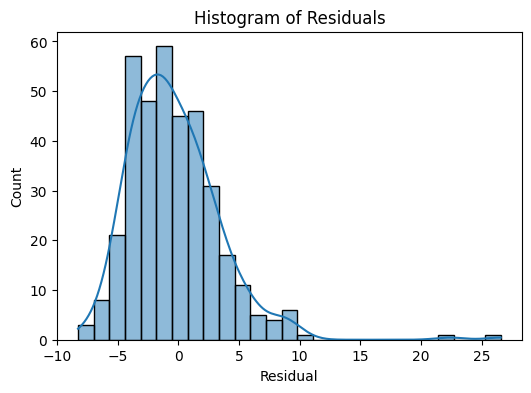

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.show()

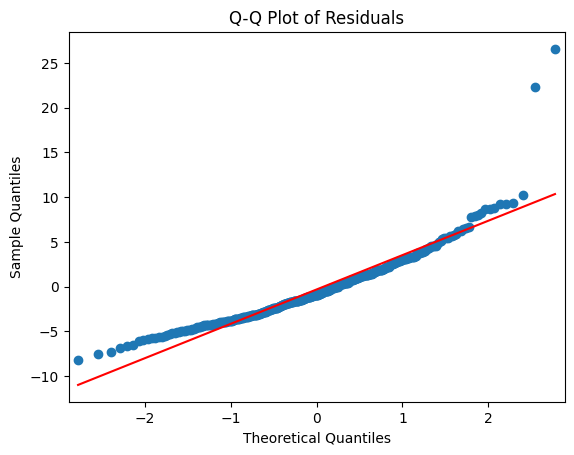

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

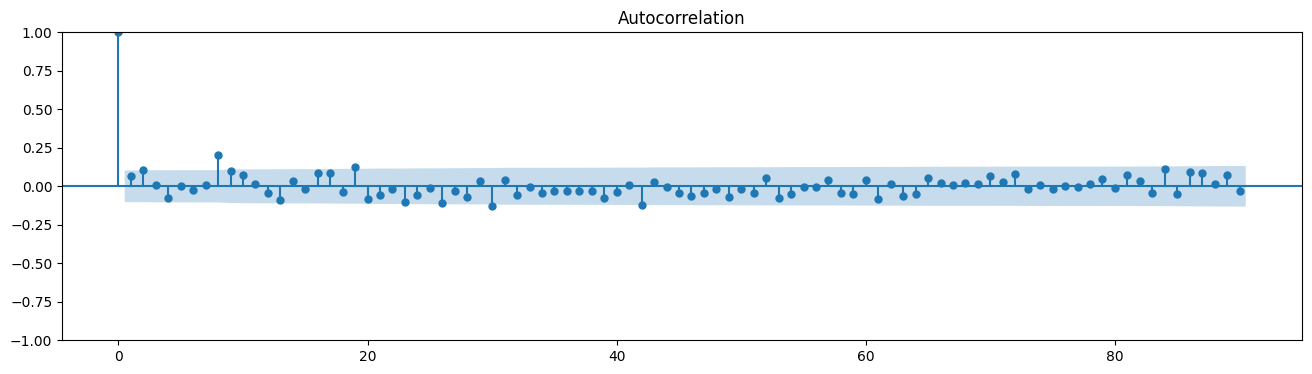

In [ ]:
plot_acf(residuals, lags=90).set_size_inches(16, 4)
plt.show()

In [ ]:
#@title Export Best Test Forecasts to CSV File

best_forecast = cv_tuned.set_index('ds')['yhat'].rename('forecast')
best_forecast.to_csv(f'{path}forecast_prophet.csv', index=True, index_label='date')